In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")  # Set seaborn style

In [3]:
#Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

1. Exploratory Data Analysis (EDA)

In [4]:
# Display dataset shape
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (1460, 81)
Test dataset shape: (1459, 80)


In [5]:
# Check for missing values and data types
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Figure size 1200x600 with 0 Axes>

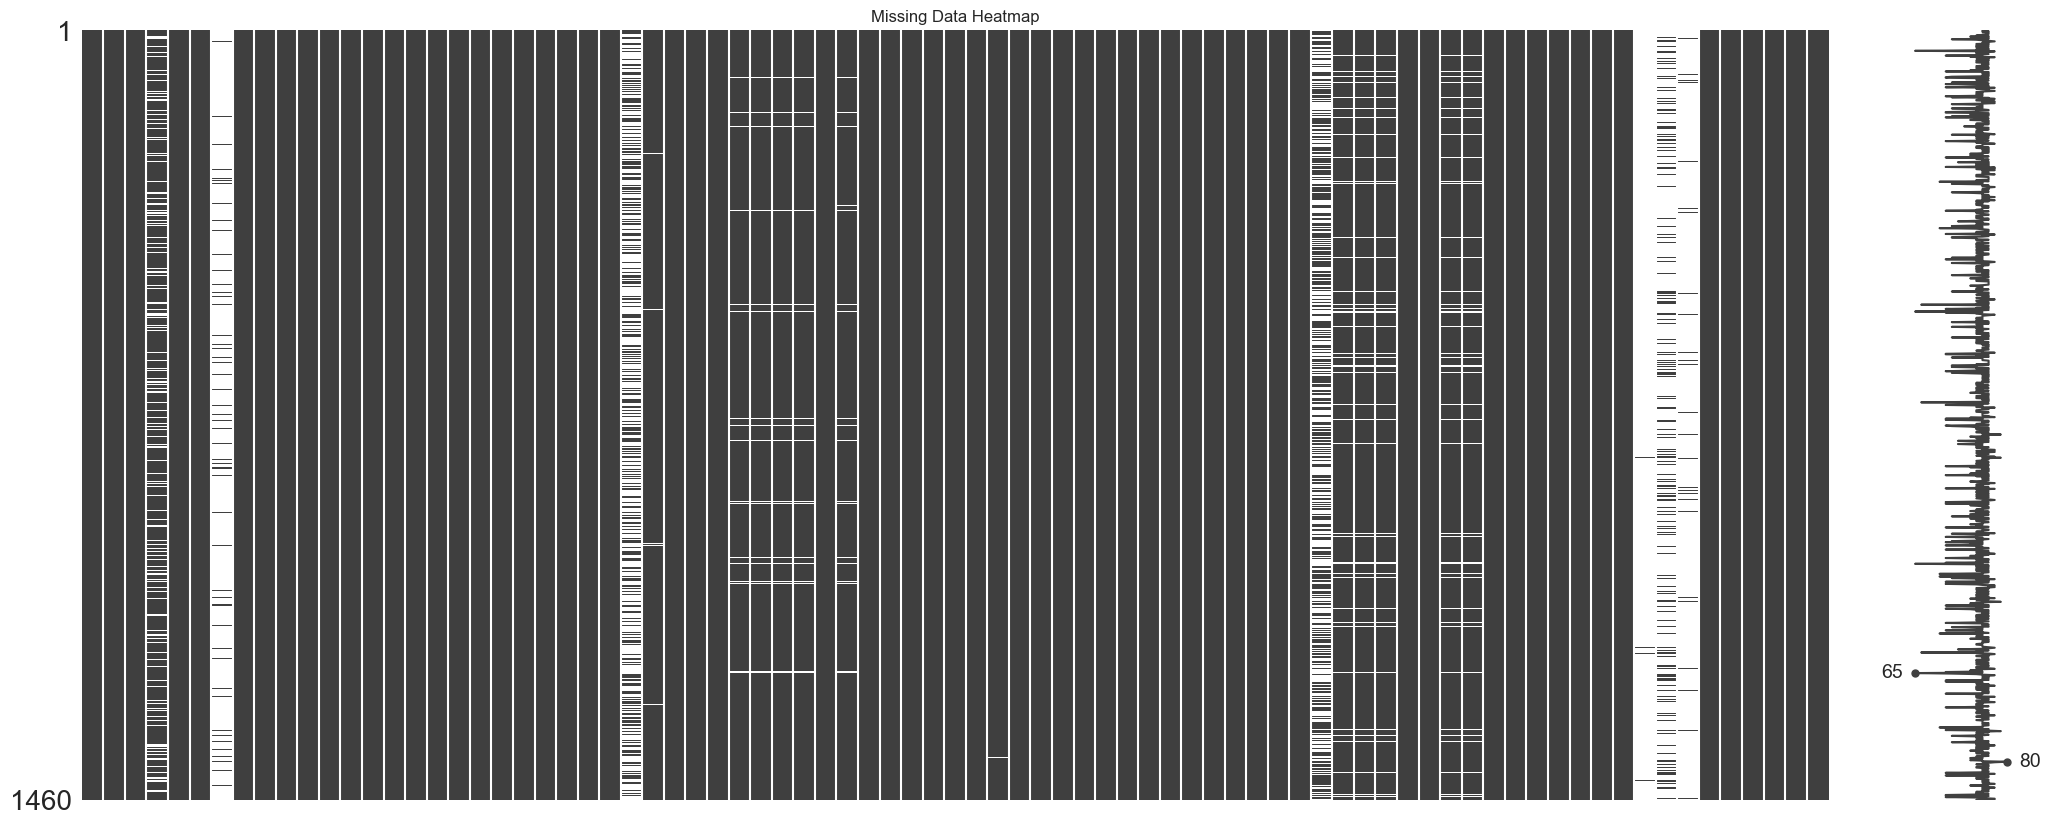

In [6]:
# Visualizing missing values by heatmap
plt.figure(figsize=(12,6))
msno.matrix(train_df)
plt.title("Missing Data Heatmap")
plt.show()

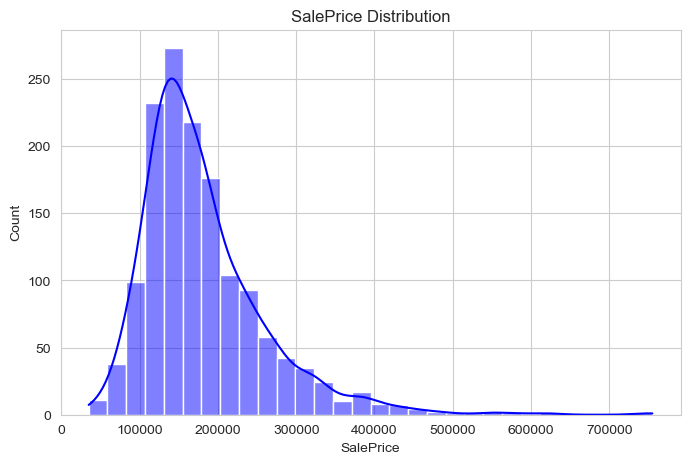

In [7]:
# Distribution of target variable (SalePrice)
plt.figure(figsize=(8,5))
sns.histplot(train_df["SalePrice"], kde=True, bins=30, color="blue")
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.show()


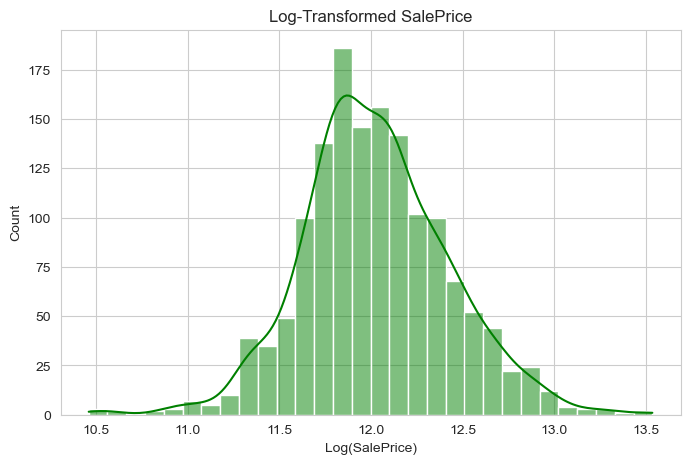

In [8]:
# Log transformation of SalePrice (to normalize skewness)
train_df["LogSalePrice"] = np.log1p(train_df["SalePrice"])
plt.figure(figsize=(8,5))
sns.histplot(train_df["LogSalePrice"], kde=True, bins=30, color="green")
plt.title("Log-Transformed SalePrice")
plt.xlabel("Log(SalePrice)")
plt.show()

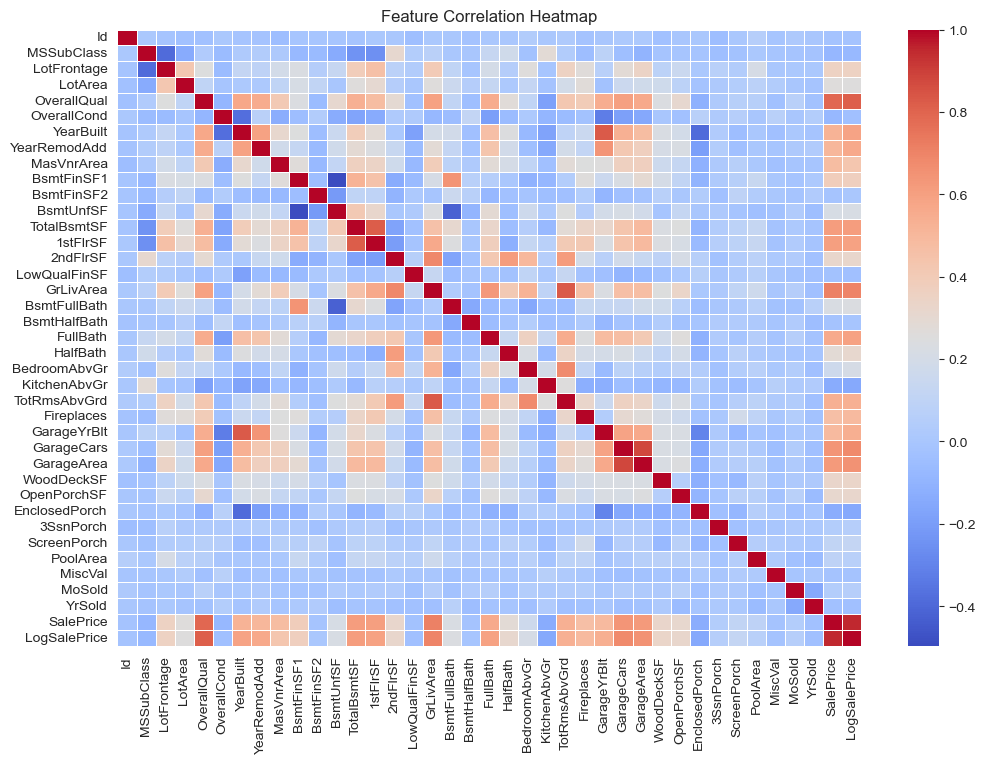

In [9]:
# Take only numerical columns
numeric_features = train_df.select_dtypes(include=[np.number])

# Correlation heatmap (to find strong predictors)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

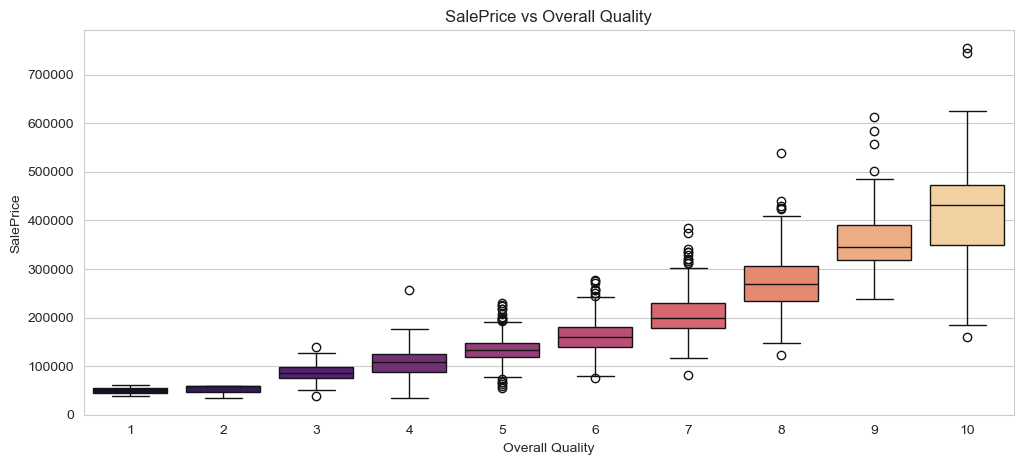

In [10]:
# Boxplot: Relationship between overall quality & SalePrice
plt.figure(figsize=(12, 5))
sns.boxplot(x=train_df["OverallQual"], y=train_df["SalePrice"], palette="magma")
plt.title("SalePrice vs Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("SalePrice")
plt.show()

2. Data Preprocessing

In [11]:
# Drop ID column (not useful for prediction)
train_df.drop(columns=["Id"], inplace=True)
test_df.drop(columns=["Id"], inplace=True)

In [12]:
# Handling missing value
imputer = SimpleImputer(strategy="median") # Replace missing values with median
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Xóa SalePrice và LogSalePrice khi xử lý vì test_df không có cột này
features_for_imputation = [col for col in numerical_features if col not in ["SalePrice", "LogSalePrice"]]
train_df[features_for_imputation] = imputer.fit_transform(train_df[features_for_imputation])
test_df[features_for_imputation] = imputer.transform(test_df[features_for_imputation])


In [13]:
# Encoding categorial variables
categorical_features = train_df.select_dtypes(include=[object]).columns.tolist()

for feature in categorical_features:
    encoder = LabelEncoder()

    # Điền NaN bằng 'Unknown' cho cả train và test
    train_df[feature] = train_df[feature].fillna("Unknown")
    test_df[feature] = test_df[feature].fillna("Unknown")

    # Gộp cả train và test lại để fit encoder (đảm bảo không có unseen labels)
    combined = pd.concat([train_df[feature], test_df[feature]], axis=0)

    # Fit encoder trên dữ liệu gộp
    encoder.fit(combined.astype(str))

    # Transform lại từng tập dữ liệu
    train_df[feature] = encoder.transform(train_df[feature].astype(str))
    test_df[feature] = encoder.transform(test_df[feature].astype(str))

In [14]:
# Define X (features) and y (target)
X = train_df.drop(["SalePrice", "LogSalePrice"], axis=1)
y = train_df["LogSalePrice"]  # Using log-transformed target variable

In [15]:
# Splitting into train & validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Standardization (for models that require scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test_df)

3. Model Training

In [17]:
# Define multiple models for comparison
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [18]:
best_model = None
best_rmse = float("inf")

In [ ]:
# Train each model & evaluate performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f"{name} RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

print(f"\nBest Model: {best_model.__class__.__name__} with RMSE: {best_rmse:.4f}")

RandomForest RMSE: 0.1443
GradientBoosting RMSE: 0.1384
XGBoost RMSE: 0.1450

✅ Best Model: GradientBoostingRegressor with RMSE: 0.1384


4. Model Evaluation

In [20]:
# Predict on validation set
y_pred_valid = best_model.predict(X_valid)
y_pred_actual = np.expm1(y_pred_valid)  # Convert back from log scale

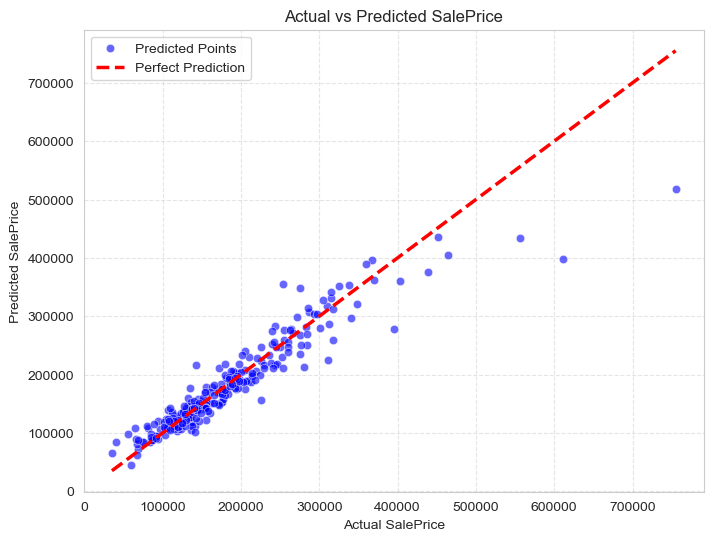

In [21]:
# Scatter plot: Actual vs. Predicted SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.expm1(y_valid), y=y_pred_actual, alpha=0.6, color="blue", label="Predicted Points")

# Đường y = x (đường hoàn hảo)
plt.plot([np.expm1(y_valid).min(), np.expm1(y_valid).max()], 
         [np.expm1(y_valid).min(), np.expm1(y_valid).max()], 
         '--r', linewidth=2.5, label="Perfect Prediction")

plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Thêm lưới để dễ quan sát
plt.show()

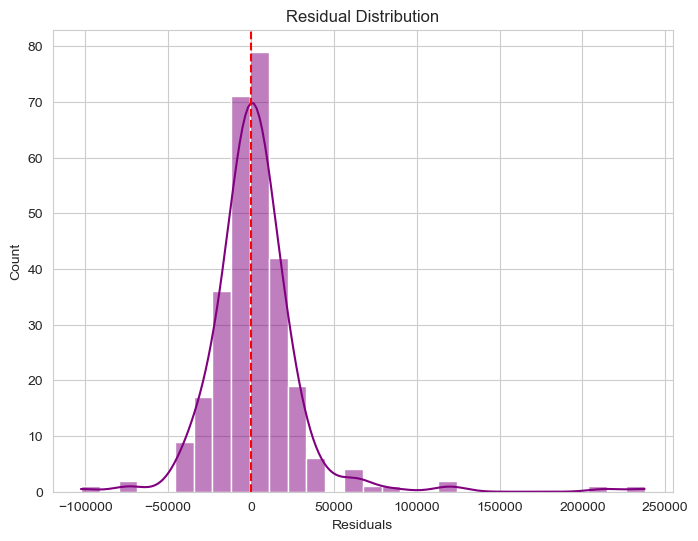

In [22]:
# Residual Plot
residuals = np.expm1(y_valid) - y_pred_actual
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.axvline(x=0, linestyle="--", color="red")
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

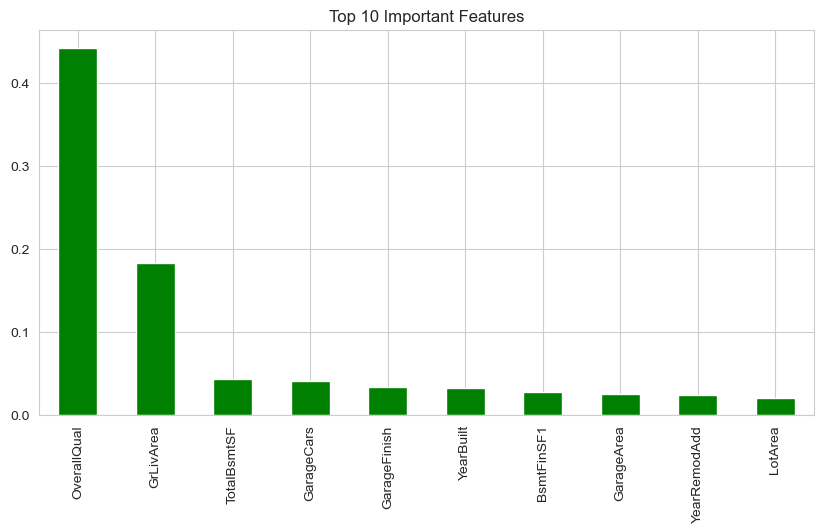

In [23]:
# Feature Importance (only for tree-based models)
if hasattr(best_model, "feature_importances_"):
    feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
    plt.figure(figsize=(10, 5))
    feature_importance.nlargest(10).plot(kind="bar", color="green")
    plt.title("Top 10 Important Features")
    plt.show()

5. Predict on Test Set

In [24]:
y_test_pred = best_model.predict(X_test)
y_test_pred_actual = np.expm1(y_test_pred)  # Convert back from log scale

In [ ]:
# Create Submission File For Kaggle Competition 
submission = pd.DataFrame({"Id": pd.read_csv("test.csv")["Id"], "SalePrice": y_test_pred_actual})
submission.to_csv("submission.csv", index=False)

print("Submission file 'submission.csv' created successfully!")


🚀 Submission file 'submission.csv' created successfully!


6. Compare with sample submission

In [ ]:
# Đọc dữ liệu
submission = pd.read_csv("submission.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Kiểm tra kích thước
print("Submission shape:", submission.shape)
print("Sample Submission shape:", sample_submission.shape)

# Kiểm tra 5 dòng đầu tiên
print("Your Submission:\n", submission.head())
print("Sample Submission:\n", sample_submission.head())

Submission shape: (1459, 2)
Sample Submission shape: (1459, 2)
📌 Your Submission:
      Id      SalePrice
0  1461  122289.910661
1  1462  148768.469003
2  1463  176759.650834
3  1464  185884.536719
4  1465  196847.041236
📌 Sample Submission:
      Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977


In [ ]:
# So sánh xem có thiếu cột hoặc khác cột không
print("Different columns:", set(submission.columns) ^ set(sample_submission.columns))

🔍 Different columns: set()


In [ ]:
# So sánh ID để xem có trùng khớp không
print("IDs match:", submission["Id"].equals(sample_submission["Id"]))

🔍 IDs match: True


In [ ]:
# Tính sai số trung bình (Mean Absolute Error - MAE)
mae = np.mean(np.abs(submission["SalePrice"] - sample_submission["SalePrice"]))
print(f"Mean Absolute Error (MAE): {mae}")

📊 Mean Absolute Error (MAE): 54172.764879156006


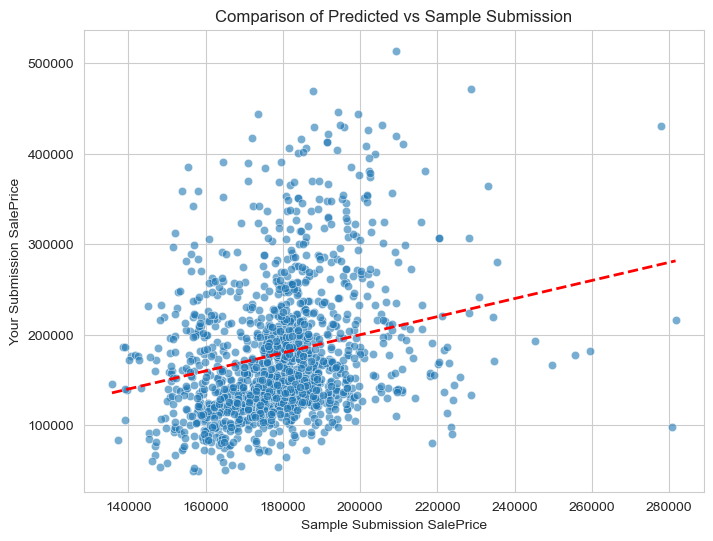

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sample_submission["SalePrice"], y=submission["SalePrice"], alpha=0.6)
plt.plot([sample_submission["SalePrice"].min(), sample_submission["SalePrice"].max()], 
         [sample_submission["SalePrice"].min(), sample_submission["SalePrice"].max()], '--r', linewidth=2)
plt.xlabel("Sample Submission SalePrice")
plt.ylabel("Your Submission SalePrice")
plt.title("Comparison of Predicted vs Sample Submission")
plt.show()